<a href="https://colab.research.google.com/github/PomesHouse/SkillTreePython-DeepLearning/blob/main/04.Paper-with-code/ch04_03_Generative_Model_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ch04.03 Generative Model - DCGAN

* 날짜:
* 이름:

## 학습내용
    - 딥러닝 생성모델에 대해 이해한다.
    - Deep Convolutional Generative Adversarial Networks 를 구현한다.

> https://arxiv.org/pdf/1406.2661.pdf



## 실습
---

### | **모델 구현**
<p  align='center'>
<img src ='https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0403-02.PNG?raw=true' width=800>
</p>

In [3]:
# discriminator는 가벼울 수록 좋고, generator는 복잡할 수록 좋다.

import tensorflow as tf
from tensorflow.keras import models, layers, utils

def build_gen(z_dim = 64, img_shape = (28, 28, 1)):
    h, w, c = img_shape
    # 길이가 (z_dim) 벡터
    z = layers.Input(shape = [z_dim] ) 
    y = layers.Dense( int(w/4) * int(h/4) * 128,)(z)  #activation = 'relu' )(z)
    y = layers.Reshape([int(w/4) , int(h/4), 128])(y)

    y = layers.BatchNormalization()(y)
    y = layers.Conv2DTranspose(64, kernel_size = 5, padding = 'same', strides = 2, activation = 'relu')(y) 
    y = layers.BatchNormalization()(y)
    
    # 크기가 img_shape = (h, w, c) 텐서
    y = layers.Conv2DTranspose(c, kernel_size = 5, padding = 'same', strides = 2, activation = 'sigmoid')(y)  
    
    return models.Model(z, y, name = 'Generator')

def build_dis(img_shape = (28, 28, 1)):
    x = layers.Input(shape = img_shape)
    y = layers.Conv2D(64, kernel_size = 5, strides = 2, padding = 'same', activation = 'relu')(x)
    y = layers.Dropout(.5)(y)
    y = layers.Conv2D(128, kernel_size = 5, strides = 2, padding = 'same', activation = 'relu')(y)
    y = layers.Dropout(.5)(y)
    y = layers.Flatten()(y)

    y = layers.Dense(1, activation = 'sigmoid')(y)

    return models.Model(x, y, name = 'Discriminator')

g = build_gen(128, (32, 32, 3) )
g.summary()

d = build_dis((32, 32, 3))
d.summary()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128)]             0         
                                                                 
 dense_4 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape_2 (Reshape)         (None, 8, 8, 128)         0         
                                                                 
 batch_normalization_4 (Batc  (None, 8, 8, 128)        512       
 hNormalization)                                                 
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 16, 16, 64)       204864    
 ranspose)                                                       
                                                                 
 batch_normalization_5 (Batc  (None, 16, 16, 64)       25

(1, 128) (1, 32, 32, 3)


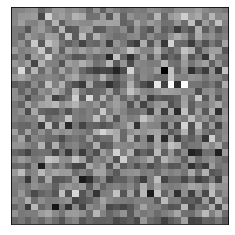

[[0.48734754]]


In [7]:
import matplotlib.pyplot as plt

z = tf.random.normal([1, 128])
fake_img = g.predict(z)
print(z.shape, fake_img.shape)
plt.imshow(fake_img[0, :, :, 0], cmap = 'gray'); plt.xticks([]); plt.yticks([])
plt.show()

logit = d.predict(fake_img)
print(logit)

#### | 데이터

In [12]:
batch_size = 32

# def get_mnist():
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train /255. # float으로 나누어주기 습관화 
x_train = np.expand_dims(x_train, 3)
ds = tf.data.Dataset.from_tensor_slices(x_train)
ds = ds.batch(batch_size, drop_remainder = True ).prefetch(1)

for x in ds: # ds.take(1)
    print(x.shape) # 이미지
    break

(32, 28, 28, 1)


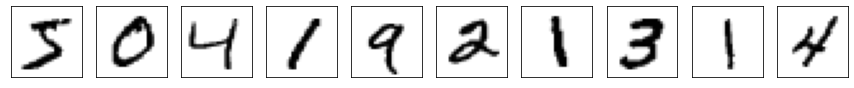

In [19]:
def display_sample_img(samples, cmap='gray_r'):
  plt.figure(figsize=(15,3))
  for i,sample in enumerate(samples):
    #sample = ( sample  + 1. ) / 2.
    #sample = np.clip(sample, 0, 1)
    if i==10:break
    plt.subplot(1,10,i+1)
    if sample.shape[-1]==1: plt.imshow(sample[:,:,0], cmap=cmap)
    else: plt.imshow(sample)
    plt.xticks([]);plt.yticks([])
  plt.show()

display_sample_img(x_train[:10])

### **| 학습**
<p  align='center'>
<img src ='https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0403-01.PNG?raw=true' width=600>
</p>

In [8]:
import numpy as np
import matplotlib.pyplot as plt

In [17]:
ones = tf.constant([1.], shape = [batch_size, 1])
zeros = tf.constant([0.], shape = [batch_size, 1])

print(ones.shape,  zeros.shape)

(32, 1) (32, 1)


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 100)]             0         
                                                                 
 Generator (Functional)      (None, 28, 28, 1)         840705    
                                                                 
 Discriminator (Functional)  (None, 1)                 212865    
                                                                 
Total params: 1,053,570
Trainable params: 840,321
Non-trainable params: 213,249
_________________________________________________________________


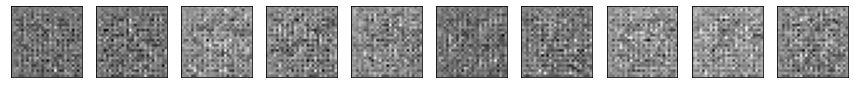

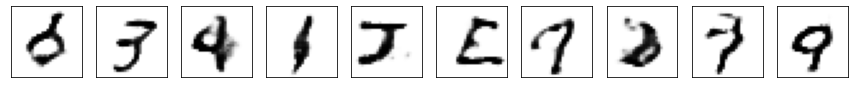

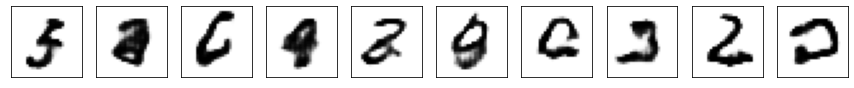

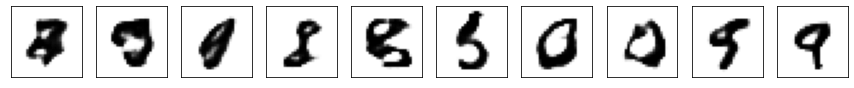

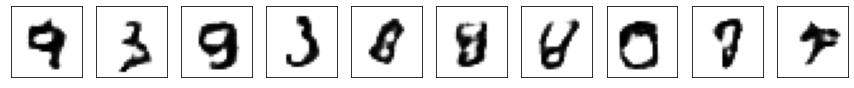

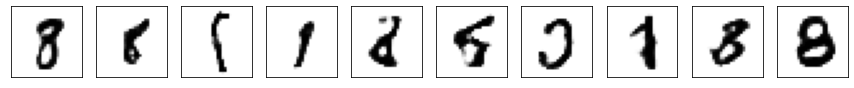

In [25]:
noise_dims = 100
epochs = 5
batch_size = 32
img_shape = (28,28,1)

# 모델 만들기
G = build_gen(noise_dims, img_shape)
D = build_dis(img_shape) 

# 컴파일
loss = 'binary_crossentropy'
optimizer = 'adam'
D.compile(loss = loss, optimizer = optimizer)
D.trainable = False
input_noise = layers.Input(shape=noise_dims)
fake_img = G(input_noise)
logit = D(fake_img)
GAN = models.Model(input_noise, logit)
GAN.compile(loss = loss, optimizer = optimizer)
GAN.summary()

# 학습
for epoch in range(epochs+1):
  if epoch!=0:
    for real_imgs in ds:
      noises = tf.random.normal(shape=[batch_size, noise_dims]) # p (가우시안 확률분포)
      fake_imgs = G.predict_on_batch(noises)
      # real_imgs: 이미 정의 되어 있다.
      # print(noises.shape) # z [100]
      # print(real_imgs.shape) # x [28, 28, 1]
      
      # phase 1. 판별자 훈련
      D.trainable = True
      # 진짜 이미지 (real_imgs) 가 들어오면 1로 대답
      D_loss_real = D.train_on_batch(real_imgs, ones)
      # 가짜 이미지 (fake_imgs = G(noises)) 가 들어오면 0으로 대답
      D_loss_fake = D.train_on_batch(fake_imgs, zeros)
      D_loss = ( 0.5*D_loss_real + 0.5*D_loss_fake ) / float(batch_size)
      
      # phase 2. 생성자 훈련
      D.trainable = False
      noises = tf.random.normal(shape=[batch_size, noise_dims])
      G_loss = GAN.train_on_batch(noises, ones) 

  noises = tf.random.normal(shape=[batch_size, noise_dims])
  fake_imgs = G.predict(noises)
  display_sample_img(fake_imgs[:10])

In [5]:
def build_gan(z_dim, img_shape):
    gen = build_gen(z_dim, img_shape)
    dis = build_dis(img_shape)

    z = layers.Input(shape = [z_dim] ) 
    fake_img = gen(z)
    logit = dis(fake_img)
    return models.Model(z, logit, name = 'GAN')

gan = build_gan(128, (32, 32, 3))
gan.summary()

Model: "GAN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 128)]             0         
                                                                 
 Generator (Functional)      (None, 32, 32, 3)         1267203   
                                                                 
 Discriminator (Functional)  (None, 1)                 217985    
                                                                 
Total params: 1,485,188
Trainable params: 1,484,804
Non-trainable params: 384
_________________________________________________________________


###Fashion-MNIST

In [31]:
import tensorflow as tf

batch_size = 32
(x_train, _) , (_, _) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train / 255.
x_train = np.expand_dims(x_train, 3)

ds = tf.data.Dataset.from_tensor_slices(x_train)
ds = ds.batch(batch_size, drop_remainder = True).prefetch(1)

for x in ds:
    print(x.shape) 
    break

(32, 28, 28, 1)


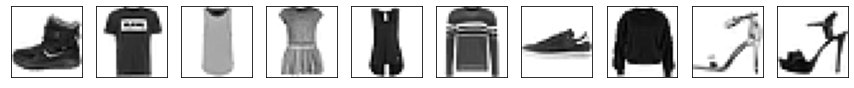

In [29]:
def display_sample_img(samples, cmap='gray_r'):
  plt.figure(figsize=(15,3))
  for i,sample in enumerate(samples):
    #sample = ( sample  + 1. ) / 2.
    #sample = np.clip(sample, 0, 1)
    if i==10:break
    plt.subplot(1,10,i+1)
    if sample.shape[-1]==1: plt.imshow(sample[:,:,0], cmap=cmap)
    else: plt.imshow(sample)
    plt.xticks([]);plt.yticks([])
  plt.show()

display_sample_img(x_train[:10])

In [32]:
ones = tf.constant([1.], shape=[batch_size, 1])
zeros = tf.constant([0.], shape=[batch_size, 1])
ones.shape, zeros.shape

(TensorShape([32, 1]), TensorShape([32, 1]))

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 100)]             0         
                                                                 
 Generator (Functional)      (None, 28, 28, 1)         840705    
                                                                 
 Discriminator (Functional)  (None, 1)                 212865    
                                                                 
Total params: 1,053,570
Trainable params: 840,321
Non-trainable params: 213,249
_________________________________________________________________


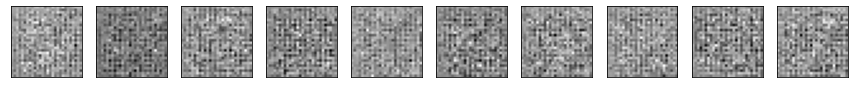

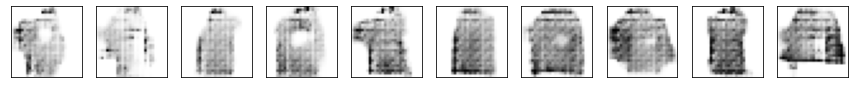

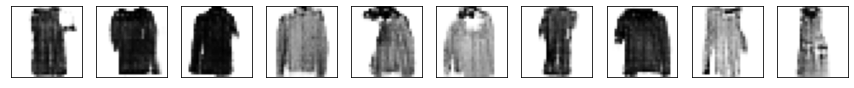

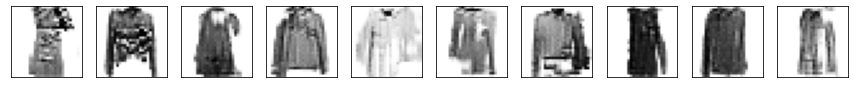

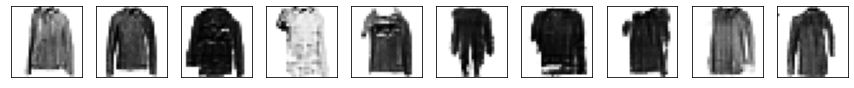

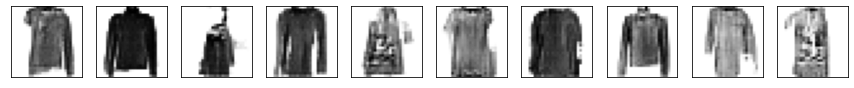

In [33]:

noise_dims = 100
epochs = 5
batch_size = 32
img_shape = (28,28,1)

# 모델 만들기
G = build_gen(noise_dims, img_shape)
D = build_dis(img_shape) 

# 컴파일
loss = 'binary_crossentropy'
optimizer = 'adam'
D.compile(loss = loss, optimizer = optimizer)
D.trainable = False
input_noise = layers.Input(shape=noise_dims)
fake_img = G(input_noise)
logit = D(fake_img)
GAN = models.Model(input_noise, logit)
GAN.compile(loss = loss, optimizer = optimizer)
GAN.summary()

# 학습
for epoch in range(epochs+1):
  if epoch!=0:
    for real_imgs in ds:
      noises = tf.random.normal(shape=[batch_size, noise_dims]) # p (가우시안 확률분포)
      fake_imgs = G.predict_on_batch(noises)
      
      # phase 1. 판별자 훈련
      D.trainable = True
      # 진짜 이미지 (real_imgs) 가 들어오면 1로 대답
      D_loss_real = D.train_on_batch(real_imgs, ones)
      # 가짜 이미지 (fake_imgs = G(noises)) 가 들어오면 0으로 대답
      D_loss_fake = D.train_on_batch(fake_imgs, zeros)
      D_loss = ( 0.5*D_loss_real + 0.5*D_loss_fake ) / float(batch_size)
      
      # phase 2. 생성자 훈련
      D.trainable = False
      noises = tf.random.normal(shape=[batch_size, noise_dims])
      G_loss = GAN.train_on_batch(noises, ones) 

  noises = tf.random.normal(shape=[batch_size, noise_dims])
  fake_imgs = G.predict(noises)
  display_sample_img(fake_imgs[:10])